# BTVC - KTRLite

In this section, we will cover:

- KTRLite model structure
- Syntax to call KTRLite class
- Utilities to check/visualize knot fitting results

BTVC stands for Bayesian Time Varying Coefficient model. It's a class of varying coefficient regression models. The novelty comes from that we adopt a Bayesian framework by assuming the latent local variables follow certain probabilistic distributions, and then a kernel-based smoothing technique is used to produce the dynamic coefficients.

For more details, please refer to our white paper at arxiv [to be added].

In [1]:
import pandas as pd
import numpy as np
from orbit.models.ktrlite import KTRLiteMAP

from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components, plot_ktr_lev_knots
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Model Structure

Our focus is a multiple regression model with time-varying coefficients of the following form


$$y_t = l_t + s_t + X_t^T\beta_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $y_t$ is the response variable, $l_t$ is the trend term,  $s_t$ is the seasonality term,  $\beta_t = \beta(t)$ is a $p$-dimensional vector of coefficients which vary over time,  $X_t$ is a $p$-dimensional covariate, and $\epsilon_t$ is a stationary random error process.

We assume

\begin{equation}
\beta_{i,t} = \sum_{j=1}^{m} w_j(t) \cdot b_{i,j}, 
\end{equation}

where $i=1,\cdots,p, ~t=1,\cdots, T,~j=1,\cdots, m$. $p$ denotes the number of predictors,  $T$ the number of time points, $m$ the number of local weighting variables.  The local variables $b_{i,j}$ can be viewed as the ``knots" from the perspective of spline regression located at time $t_j, ~j=1,  \cdots,  m$.  $[t_1,  \cdots, t_m]$ is a subset of $[1, \cdots, T]$.  We can write the coefficient function for the $i$-th covariate as

$$\beta_i(t) = \beta(t, b_i),$$

where $b_i=[b_{i1}, b_{i2}, \cdots, b_{im}]$.  Or, simply in matrix form as

$$\beta=Kb^T,$$

where $\beta$ is the coefficient matrix with size $T\times p$, $K$ is the kernel matrix with size $T\times m$, and $b$ is the knot matrix with size $p\times m$.  Specifically,  the entry of matrix $K$ is the weight $w_j(t)$. We use kernel function as the weighting function,  i.e.,

$$w_j(t) = k_h(t_j, t)/\sum_{j=1}^{m} k_h(t_j, t),$$

where $k_h(\cdot, \cdot)$ is the kernel function, $h$ is the bandwidth.  The denominator is in order to have normalized weights that sum up to one.  In practice, we could use different kernels,  such as Gaussian kernel,  quadratic kernel  or any other customized kernel.

For the level/trend,

$$l_t = \beta_{\text{lev}},$$
$$\beta_{\text{lev}} = K_{\text{lev}}b^T_{\text{lev}}.$$
The trend term can be viewed as a dynamic intercept.

For the seasonality,
$$s = X_{\text{seas}}\beta_{\text{seas}},$$
$$\beta_{\text{seas}} = K_{\text{seas}}b^T_{\text{seas}}.$$
We use Fourier series to handle the seasonality such that seasonality terms can be expressed in a matrix $X_{seas}$.

For the regression,
$$r_\text{reg} = X_\text{reg}\beta_\text{reg},$$
$$\beta_\text{reg} = K_\text{reg}b^T_\text{reg}.$$

Instead of estimating the local knots (i.e., $b_\text{lev}$,  $b_\text{seas}$,  and $b_\text{reg}$ in the above equations) directly by optimizing an objective function,  we introduce the Bayesian priors into the framework by assuming probabilistic distributions for the local knots.

Specifically,
  
$$b^j_\text{lev} \sim \text{Laplace}(b^{j-1}_\text{lev},  \sigma_\text{lev}).$$

$$b_\text{seas} \sim \text{N}(0,  \sigma^2_\text{seas}),$$

$$\mu_\text{reg} \sim \text{N}(\mu_\text{pool}, \sigma^2_\text{pool}),$$ 
$$b_\text{reg} \sim \text{N}(\mu_\text{reg},  \sigma^2_\text{reg}),$$ 

where $\text{N}$ denotes the Gaussian distribution.

In KTRLite, there is no regression term, which is handled by KTRX. We will introduce KTRX in a separate notebook.

## Data

To illustrate the usage of KTRLite, we use the daily series of electricity demand in Turkey from year 2000 to year 2008. It is good to model the dual seasonality (weekly and yearly), since it's a daily series.

In [3]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

date_col = 'date'
response_col = 'electricity'

df[response_col] = np.log(df[response_col])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [4]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

Split the data into training set and test set.

In [5]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In orbit, we mainly provide one type of KTRLite model, `KTRLiteMAP`, using Stan as the underlying sampling engine.

Similar to other model types in Orbit, it follows a sklearn style model API. We can create an instance of the Orbit class and then call its fit and predict methods.

In [6]:
ktrlite = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.5,
    span_level=.1,
    span_coefficients=.3,
    estimator_type=StanEstimatorMAP,
)

In [7]:
ktrlite.fit(train_df)

In [8]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.36368,9.99556,10.59389,9.39855,9.98110,10.52737,0.02498,0.02498,0.02498,-0.01052,-0.01052,-0.01052
1,2008-01-03,9.35323,9.99685,10.59225,9.39438,9.98110,10.53127,0.02704,0.02704,0.02704,-0.01129,-0.01129,-0.01129
2,2008-01-04,9.36033,10.00842,10.62342,9.39022,9.98110,10.53517,0.03916,0.03916,0.03916,-0.01184,-0.01184,-0.01184
3,2008-01-05,9.29352,9.93824,10.54561,9.38606,9.98110,10.53907,-0.03068,-0.03068,-0.03068,-0.01218,-0.01218,-0.01218
4,2008-01-06,9.23018,9.88432,10.48752,9.38190,9.98110,10.54297,-0.08448,-0.08448,-0.08448,-0.01230,-0.01230,-0.01230


In [9]:
'{:.2%}'.format(smape(predicted_df['prediction'].values, test_df['electricity'].values))

'0.56%'

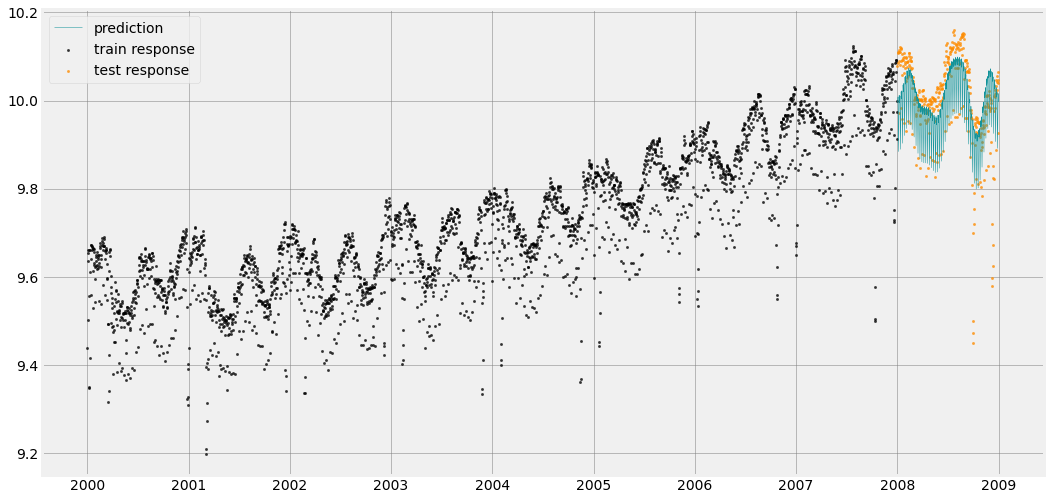

In [10]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        prediction_percentiles=[None, None],
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df, markersize=20, lw=.5)

We can use `plot_predicted_components` to visualize each component.

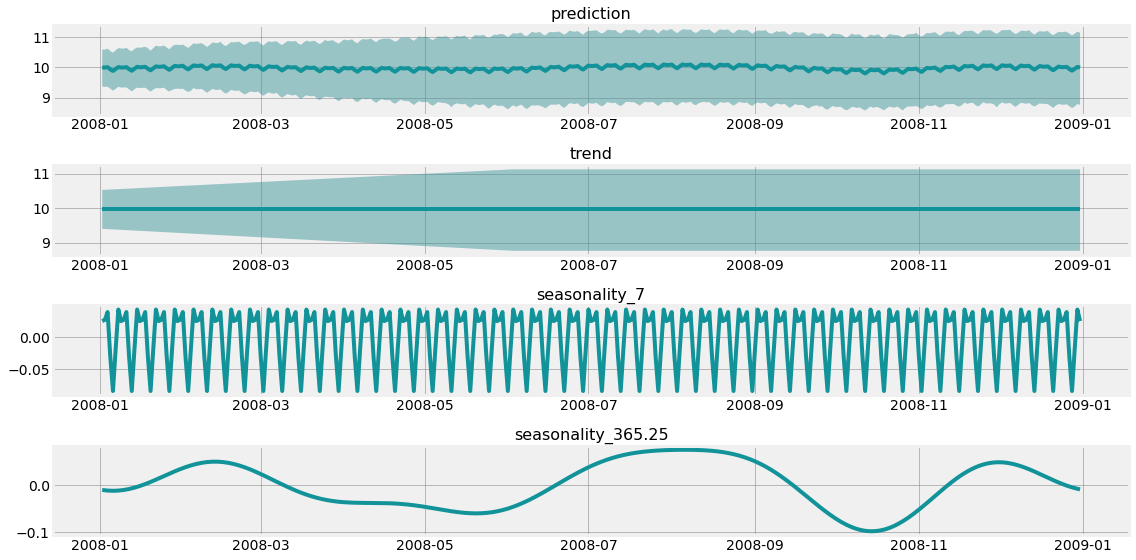

In [11]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, 
                              plot_components=['prediction', 'trend', 
                                               'seasonality_7', 'seasonality_365.25'])

Moreover, we have `plot_ktr_lev_knots` in Orbit to inspect the fitted level knots against the actual series. It could help diagnose the potential problem of the knot fitting.

In [12]:
# get the knots
lev_knots = ktrlite._aggregate_posteriors['map']['lev_knot']
lev_knots_tp_discrete = ktrlite._knots_tp_level * train_df.shape[0] - 1
td = pd.Series([pd.Timedelta(days=k) for k in lev_knots_tp_discrete])
lev_knot_dates = train_df[date_col].iloc[0] + td

full_df = pd.concat((train_df, test_df), axis=0, ignore_index=True)
decomp_df = ktrlite.predict(df=full_df, decompose=True)

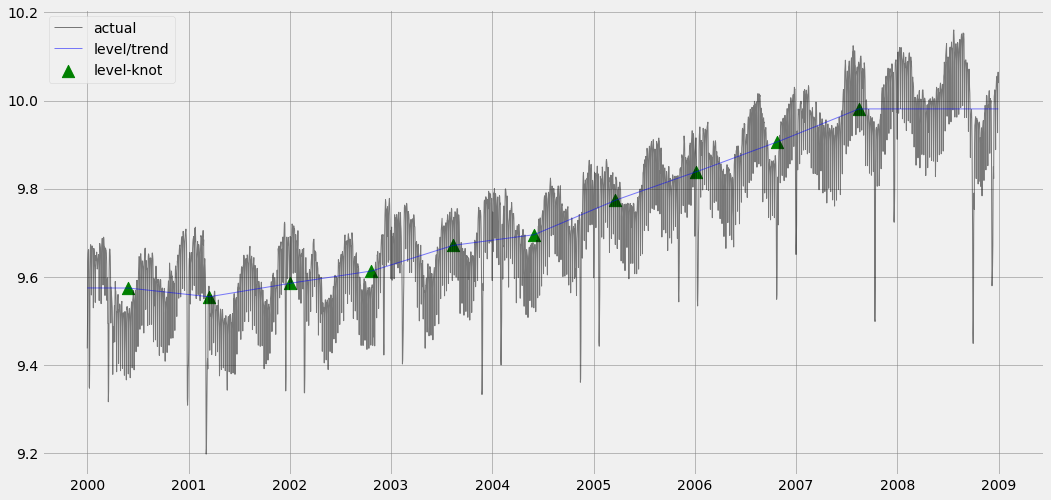

In [13]:
_ = plot_ktr_lev_knots(full_df, decomp_df, date_col, 
                       response_col, lev_knot_dates, lev_knots)